# Exercise 1.2.3: Geometric Transformations
#### By Jonathan L. Moran (jonathan.moran107@gmail.com)
From the Self-Driving Car Engineer Nanodegree programme offered at Udacity.

## Objectives

* Implement horizontal flipping and resizing;
* Implement random cropping (optional);
* Transform the associated bounding boxes.

## 1. Introduction

In our last [Exercise 1.2.2](), we performed pixel-level transformations on a set of images. In this Exercise, we will be manipulating the entire image space with geometric transformations. These type of transformations map every pixel in image to a new location via a mathematical function.

In [1]:
### Importing required modules

In [2]:
import copy
import logging
from math import floor
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import os
from PIL import Image, ImageDraw
from typing import List

In [3]:
### Setting environment variables

In [4]:
ENV_COLAB = False                # True if running in Google Colab instance

In [5]:
# Root directory
DIR_BASE = '' if not ENV_COLAB else '/content/'

In [6]:
# Subdirectory to save output files
DIR_OUT = os.path.join(DIR_BASE, 'out/')
# Subdirectory pointing to input data
DIR_SRC = os.path.join(DIR_BASE, 'data/')

### 1.1. Geometric Transformations

There are five common classifications of [geometric transformations](https://en.wikipedia.org/wiki/Geometric_transformation) —
* **[Displacements](https://en.wikipedia.org/wiki/Displacement_\(vector\))**: preserve [distances](https://en.wikipedia.org/wiki/Distance) and _oriented_ [angles](https://en.wikipedia.org/wiki/Euclidean_space#Angle);
* **[Isometries](https://en.wikipedia.org/wiki/Isometry)**: preserve angles and distances;
* **[Similarities](https://en.wikipedia.org/wiki/Similarity_\(geometry\))**: preserve angles and ratios between distances;
* **[Affine transformations](https://en.wikipedia.org/wiki/Affine_transformation)**: preserve [parallelism](https://en.wikipedia.org/wiki/Parallelism_\(geometry\));
* **[Projective transformations](https://en.wikipedia.org/wiki/Homography)**: preserve [collinearity](https://en.wikipedia.org/wiki/Collinearity_\(geometry\)).

In this exercise we will work with several geometric transformations mentioned above. Namely — 
* **Similarities** to perform _resizing_;
* **Affine transformations** to perform horizontal and vertical _shearing_;
* **Euclidean transformations** (isometries) to perform _rotations_ and _reflections_.

## 2. Programming Task

In this exercise, you will implement the following geometric transformations
from scratch: horizontal flipping and resizing in `augmentations.py`. You can also 
implement random cropping as an additional but not required exercise. Your 
implementations should not only affect the images but also the associated bounding boxes. 

<img src="data/example.png" width=90% height=90%>

#### Fetching the input data

In [7]:
def get_data(file_path: str) -> List[dict]:
    """Simple wrapper function to get JSON data."""

    try:
        with open(file_path) as f:
            ground_truth = json.load(f)
            return ground_truth
    except json.JSONDecodeError as jde:
        logging.error(jde)

In [8]:
### Fetching the bounding box data from JSON object 

In [9]:
file_path_gt = os.path.join(DIR_SRC, 'ground_truth.json')

In [10]:
ground_truth = get_data(file_path_gt)

In [11]:
def get_gt_bboxes(filename: str, ground_truth: List[dict],
                  flip_xy=False) -> tuple:
    """Returns the ground truth bounding box data for a given image.
    
    :param filename: the filename of image to fetch data for.
    :param ground_truth: the parsed ground truth data.
    :param flip_xy: indicates whether or not to flip x-y coordinates.
    :returns: tuple of `np.ndarray` objects containing the 
        ground truth bounding boxes and corresponding class labels.
    :raises: IndexError when filename is not found in dictionary.
    """
    
    def flip_coordinates(bboxes: List[List[float]]) -> List[List[float]]:
        """Returns the flipped x,y coordinates."""
        return [[bbox[1], bbox[0], bbox[3], bbox[2]]
                for bbox in bboxes]
    try:
        gt_bboxes = [g['boxes'] if not flip_xy else
                     flip_coordinates(g['boxes']) for g in ground_truth
                     if g['filename'] == filename][0]
        gt_bboxes = np.array(gt_bboxes)
        gt_classes = [g['classes'] for g in ground_truth
                      if g['filename'] == filename][0]
        gt_classes = np.array(gt_classes)
    except Exception as e:
        # Logging IndexError (filename not found) as warning
        logging.warnings.warn(message=str(filename) + str(e))
    return gt_bboxes, gt_classes

#### Considerations for our input data

**Note**: the provided 2D bounding box data has flipped $x$- and $y$-coordinate values such that
$$
\begin{align}
    \texttt{gt_bbox} = \texttt{[x1, y1, x2, y2]},
    \end{align}
$$
is now given as
$$
\begin{align}
    \texttt{gt_bbox} = \texttt{[y1, x1, y2, x2]}.
    \end{align}
$$

This has been acknowledged by the Udacity staff as an error in [this](https://knowledge.udacity.com/questions/824519) Knowledge forum post. We've covered the necessary transformation to revert coordinate pairs back to the expected form in Sect. 2.1 of [Exercise 1.1.2](https://github.com/jonathanloganmoran/ND0013-Self-Driving-Car-Engineer/blob/main/1-Object-Detection-in-Urban-Environments/Exercises/1-1-2-Data-Acquisition-Visualisation/2022-08-01-Data-Acquisition-Visualisation.ipynb) so we're including it in the `get_gt_bboxes()` method without explicit mention.

In [12]:
### From Udacity's `utils.py`

In [13]:
def display_results(img: Image, bboxes: List[List[int]], 
                    aug_img: Image, aug_bboxes: List[List[int]]):
    """Displays the original and augmented image and bounding boxes.
    
    :param img: the PIL.Image object of the original (unmodified) image.
    :param bboxes: the list of original (unmodified) bounding box coordinates.
    :param aug_img: the augmented (modified) PIL.Image object.
    :param aug_bboxes: the list of augmented (modified) bounding box coordinates.
    """
    
    f, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(img)
    for bb in bboxes:
        y1, x1, y2, x2 = bb
        rec = Rectangle((x1, y1), x2-x1, y2-y1, facecolor='none', edgecolor='r')
        ax[0].add_patch(rec)
    
    ax[1].imshow(aug_img)
    for bb in aug_bboxes:
        y1, x1, y2, x2 = bb
        rec = Rectangle((x1, y1), x2-x1, y2-y1, facecolor='none', edgecolor='r')
        ax[1].add_patch(rec)
    plt.show()

### 2.1. Affine Transformations

An affine transformation is a **geometric transformation that preserves lines and parallelism** (but not necessarily distances and angles).

#### 2.1.1. Euclidean transformation — Reflection 

The `hflip` function takes the image and bounding boxes as input and performs a 
horizontal flip. For example, an object initially on the left of the image will 
end up on the right.

In [14]:
### From Udacity's `augmentations.py`

In [15]:
def hflip(img: Image, bboxes: List[List[int]]) -> (Image, List[List[int]]):
    """Horizontally-flips the input image and bounding boxes.
    
    :param img: the PIL image object to flip horizontally.
    :param bboxes: the list of original (unmodified) bounding box coordinates.
    :returns: a tuple containing the augmented (modified) PIL.Image object
        and the list of augmented (modified) bounding box coordinates.
    """
    
    # IMPLEMENT THIS FUNCTION
    flipped_img = None
    flipped_bboxes = []
    # Load in the input image
    img_data = img.load()
    # Create the output image
    flipped_img = Image.new('RGB', img.size)
    img_draw = ImageDraw.Draw(flipped_img)
    # Perform the horizontal reflection of image points
    for u in range(flipped_img.width):
        for v in range(flipped_img.height):
            # Reverse the pixel horizontally
            u_p = img.width - u - 1
            # Add the reversed pixel to the output image
            img_draw.point(xy=(u, v), fill=img_data[u_p, v])
    # Peform horizontal flip on bounding box coordinates
    bboxes = np.array(bboxes)
    flipped_bboxes = copy.copy(bboxes)
    # Assume data in [y1, x1, y2, x2] ordering
    flipped_bboxes[:, 1] = img.width - bboxes[:, 1]    # x1_p
    flipped_bboxes[:, 3] = img.width - bboxes[:, 3]    # x2_p
    return flipped_img, flipped_bboxes

In [16]:
### Testing horizontal flip on first image in dataset
file_name_img = 'segment-1231623110026745648_480_000_500_000_with_camera_labels_38.png'
file_path_img = os.path.join(DIR_SRC, f'images/{file_name_img}')

In [17]:
### Getting the image ground truth data
gt_bboxes, gt_classes = get_gt_bboxes(file_name_img, ground_truth)

In [18]:
### Staging the image for reading with PIL
img = Image.open(file_path_img)

In [19]:
### Performing the horizontal flip of the image and its bounding boxes
flipped_img, flipped_bboxes = hflip(img, gt_bboxes)

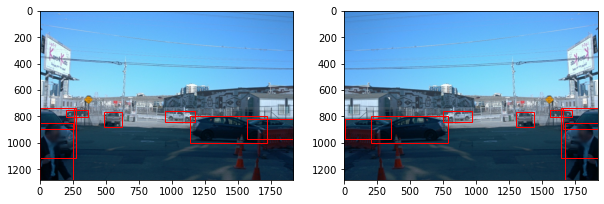

In [20]:
### Displaying the original and flipped image and bounding boxes
display_results(img, gt_bboxes, flipped_img, flipped_bboxes)

#### 2.1.2. Similarity transformation — Resizing

_Resizing_ is a specific type of affine transformation. We can replicate the result by using the following [transformation matrix](https://en.wikipedia.org/wiki/Transformation_matrix):

$$
\left(\begin{array}{ccc} 
c_{x} & 0 & 0\\
0 & c_{y} & 0\\
0 & 0 & 1\\
\end{array}\right)
$$ 

Transformation matrices are useful for displaying arbitrary linear (and some non-linear Euclidean) transformations in a consistent format. These matrices are also useful for composing multiple transformations as they can be "chained" together with matrix multiplication.

Using the Pillow Image library to perform the actual transformation, we can divide each dimension of the image by 2 using the transformation matrix parameters $c_{x} = 0.5$ and $c_{y} = 0.5$.

In [21]:
### Loading the first image in dataset
file_name_img = 'segment-1231623110026745648_480_000_500_000_with_camera_labels_38.png'
file_path_img = os.path.join(DIR_SRC, f'images/{file_name_img}')
img = Image.open(file_path_img)

In [22]:
### Defining the transformation matrix with resizing factor
c_x, c_y = 0.5, 0.5
transformation_matrix = np.array([[c_x, 0, 0], [0, c_y, 0], [0, 0, 1]])
transformation_inv = np.linalg.inv(transformation_matrix)

In [23]:
img_resized = img.transform((960, 640), method=Image.Transform.AFFINE, 
                            data=transformation_inv.flatten())
print(f'The image size is {img_resized.size}')

The image size is (960, 640)


The `resize` function takes the image, bounding boxes and target size as input. 
It scales up or down images and bounding boxes.


In [24]:
### From Udacity's `augmentations.py`

In [25]:
def resize(img: Image, bboxes: List[List[int]], 
           target_size: List[int]) -> (Image, List[List[int]]):
    """Resizes the image and bounding boxes to the target size.
    
    Resizing, i.e., scaling is performed with a nearest neighbors algorithm.
    
    :param img: the PIL.Image object to flip horizontally.
    :param bboxes: the list of original (unmodified) bounding box coordinates.
    :param target_size: the (width, height) of output (resized) image.
    :returns: a tuple containing the augmented (modified) PIL.Image object
        and the list of augmented (modified) bounding box coordinates.
    """
    
    # IMPLEMENT THIS FUNCTION
    resized_img = None
    resized_bboxes = []
    assert len(target_size) == 2
    # Read in the image data
    img_data = img.load()
    # Create the output image
    resized_img = Image.new('RGB', target_size)
    img_draw = ImageDraw.Draw(resized_img)
    # Scale the original image dimensions
    x_scale = img.width / resized_img.width
    y_scale = img.height / resized_img.height
    # Scaling the image to target size
    for u in range(resized_img.width):
        for v in range(resized_img.height):
            u_p, v_p = floor(u * x_scale), floor(v * y_scale)
            img_draw.point(xy=(u, v), fill=img_data[u_p, v_p])
    # Scaling the bounding boxes to target size
    bboxes = np.array(bboxes)
    resized_bboxes = copy.copy(bboxes)
    # Assume data in [y1, x1, y2, x2] ordering
    resized_bboxes[:, [1, 3]] = bboxes[:, [1, 3]] // x_scale    # x1_p, x2_p
    resized_bboxes[:, [0, 2]] = bboxes[:, [0, 2]] // y_scale    # y1_p, y2_p
    return resized_img, resized_bboxes

In [26]:
### Testing resize on first image in dataset
file_name_img_to_resize = 'segment-1231623110026745648_480_000_500_000_with_camera_labels_38.png'
file_path_img_to_resize = os.path.join(DIR_SRC, f'images/{file_name_img_to_resize}')

In [27]:
### Getting the image ground truth data
gt_bboxes_to_resize, gt_classes_to_resize = get_gt_bboxes(file_name_img_to_resize, ground_truth)

In [28]:
### Staging the image for reading with PIL
img_to_resize = Image.open(file_path_img_to_resize)

In [29]:
### Performing the resizing of the image and its bounding boxes
target_size = [640, 640]
resized_img, resized_bboxes = resize(img_to_resize, gt_bboxes_to_resize, target_size)

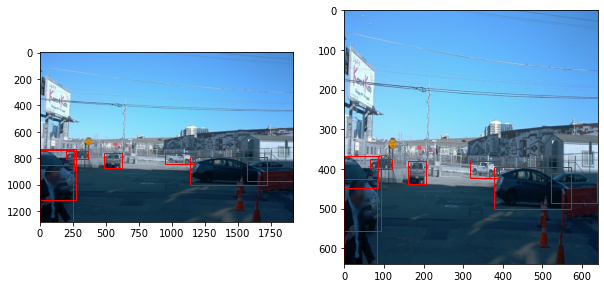

In [30]:
### Displaying the original and resized image and bounding boxes
display_results(img_to_resize, gt_bboxes_to_resize, resized_img, resized_bboxes)

In [31]:
print('Original size:', img_to_resize.size, '\nOutput size:  ', resized_img.size)

Original size: (1920, 1280) 
Output size:   (640, 640)


#### 2.1.3 Isometry transformation — Translation

We can use the same Pillow `Image.transform()` function to perform _translation_

$$
\left(\begin{array}{ccc} 
1 & 0 & t_{x}\\
0 & 1 & t_{y}\\
0 & 0 & 1\\
\end{array}\right)
$$ 

For example, we are going to translate the image by 200 pixels right and 100 pixels down respectively. We will use $t_{x}=200$ and  $t_{y}=100$

In [32]:
### Loading the first image in dataset
file_name_img = 'segment-1231623110026745648_480_000_500_000_with_camera_labels_38.png'
file_path_img = os.path.join(DIR_SRC, f'images/{file_name_img}')
img = Image.open(file_path_img)

In [33]:
### Defining the translation parameters
t_x, t_y = 200, 100
### Defining the transformation matrix and obtaining its inverse
transformation_matrix = np.array([[1, 0, t_x], [0, 1, t_y], [0, 0, 1]])
transformation_inv = np.linalg.inv(transformation_matrix)

In [34]:
### Transforming the image with a translation
translated_img = img.transform(img.size, method=Image.Transform.AFFINE, 
                               data=transformation_inv.flatten())

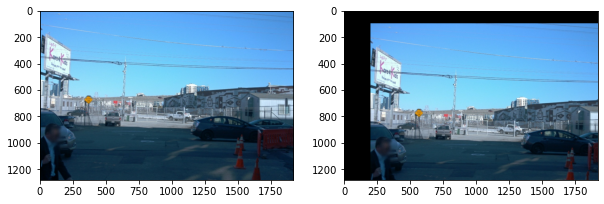

In [35]:
### Displaying the original and translated image
display_results(img, [], translated_img, [])

#### 2.1.4. Shearing

We can also use the same Pillow `Image.transform()` function to perform horizontal or vertical _shearing_:

$$
\left(\begin{array}{ccc} 
1 & s_{x} & 0\\
s_{y} & 1 & 0\\
0 & 0 & 1\\
\end{array}\right)
$$ 

For example, we are going to shear the image by a ratio of 0.1 along the $x$-axis and 1.0 along the $y$-axis. We will use $s_{x} = 0.1$ and $x_{y} = 1$.

In [36]:
### Defining the shearing parameters
s_x, s_y = 0.1, 1.0
### Defining the transformation matrix and obtaining its inverse
transformation_matrix = np.array([[1, s_x, 0], [0, s_y, 0], [0, 0, 1]])
transformation_inv = np.linalg.inv(transformation_matrix)

In [37]:
### Transforming the image with shearing
sheared_img = img.transform(img.size, method=Image.Transform.AFFINE, 
                            data=transformation_inv.flatten())

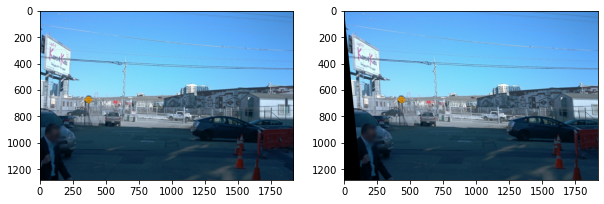

In [38]:
### Displaying the original and sheared image
display_results(img, [], sheared_img, [])

#### 2.1.5. Combining transformations

Putting together the transformations we've learned — _translation_, _shearing_ and _resizng_, we can obtain a combined transformation matrix that can be used to modify the input image in Pillow exactly as before.

In [39]:
### Defining the translation matrix s.t. t_x = 200, t_y = 100
translation = np.array([[1, 0, 200], [0, 1, 100], [0, 0, 1]])
### Defining the shearing matrix s.t. s_x = 0.1, s_y = 1.0
shearing = np.array([[1, 0.1, 0], [0, 1, 0], [0, 0, 1]])
# Defining the resizing matrix s.t. c_x, c_y = 0.5
resizing = np.array([[0.5, 0, 0], [0, 0.5, 0], [0, 0, 1]])

In [40]:
### Obtaining the combined transformation matrix using matrix multiplication
transformation_matrix = np.matmul(translation @ resizing, shearing)
transformation_inv = np.linalg.inv(transformation_matrix)

In [41]:
### Transforming the image with combined affine transformations
combined_img = img.transform(img.size, method=Image.Transform.AFFINE, 
                             data=transformation_inv.flatten())

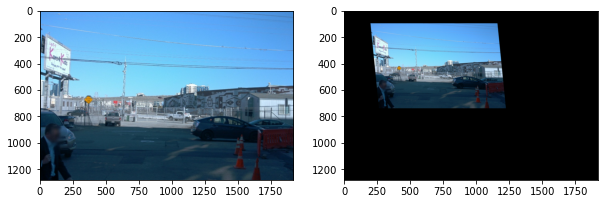

In [42]:
### Displaying the original and affine transformed (translated, sheared) image
display_results(img, [], combined_img, [])

### 2.2. Other Transformations

#### 2.2.1. Cropping

The `random_crop` function takes a few additional inputs. It also needs the classes, 
the crop size and the minimum area. Let's explain these parameters:
* `crop_size` is the size of the crop. It should be smaller than the dimensions of the input image.
* `min_area` is the minimum area of a bounding boxes to be considered as an object after cropping.

Because we are cropping randomly, we may only keep a tiny portion of an object, in which
case the annotations will not be useful anymore. For example, in the image below, we may not want to keep the annotation of the cat because most of the animal's body is not visible.

<img src="data/cat_cropped.png" width=40% height=40%>

###### Bounding box translation methods

In [43]:
### From J. Moran's `2022-07-25-Choosing-Metrics-IoU.ipynb`

In [44]:
def overlapping_rectangles(bbox1: List[int], bbox2: List[int]) -> bool:
    """Returns True if the bounding boxes overlap.

    Two bounding boxes overlap if their area is positive and non-zero.

    :param bbox1: 1x4 list of x-y coordinates forming a rectangle.
    :param bbox2: 1x4 list of x-y coordinates forming a rectangle.
    :returns: bool, whether or not the two rectangles overlap.
    """

    # 1. Check if bounding boxes do not overlap
    if (
        # (a) First bbox lower edge is GEQ second bbox upper edge
        (min(bbox1[1], bbox2[1]) >= max(bbox1[3], bbox2[3])) or
        # (b) First bbox right edge is LEQ second bbox left edge
        (min(bbox1[2], bbox2[2]) <= max(bbox1[0], bbox2[0])) or
        # (c) First bbox left edge is GEQ second bbox right edge
        (min(bbox1[0], bbox2[0]) >= max(bbox1[2], bbox2[2])) or
        # (d) First bbox upper edge is LEQ second bbox lower edge
        (min(bbox1[3], bbox2[3]) <= max(bbox1[1], bbox2[1]))
    ):
        return False
    # 2. Check if intersection area is larger than 0
    else:
        x_inter1 = max(bbox1[0], bbox2[0])
        y_inter1 = max(bbox1[1], bbox2[1])
        x_inter2 = min(bbox1[2], bbox2[2])
        y_inter2 = min(bbox1[3], bbox2[3])
        # Overlapping region must have positive area
        w_inter = max(0, (x_inter2 - x_inter1))
        h_inter = max(0, (y_inter2 - y_inter1))
        if (w_inter * h_inter) > 0:
            return True
    return False

In [45]:
def get_area_intersection(bbox1: List[int], bbox2: List[int]) -> int:
    """Returns the area of intersection between two bounding boxes.
    
    Assumes that the bounding boxes are rectangles orthogonal to 
    the 2D x-y plane.
    
    :param bbox1: 1x4 list of bounding box coordinates.
    :param bbox2: 1x4 list of bounding box coordinates.
    :returns: int, the area of intersection.
    """
    
    # 1. Check if bounding boxes overlap
    if not overlapping_rectangles(bbox1, bbox2):
        return 0.0
    else:
        # 2. Find the coordinates of the area of intersection
        #    2a. The upper-left coordinate
        x_inter1 = max(bbox1[0], bbox2[0])
        y_inter1 = max(bbox1[1], bbox2[1])
        #    2b. The lower-right coordinate
        x_inter2 = min(bbox1[2], bbox2[2])
        y_inter2 = min(bbox1[3], bbox2[3])
        # 3. Calculate the area of intersection
        w_inter = max(0, x_inter2 - x_inter1)
        h_inter = max(0, y_inter2 - y_inter1)
        area_inter = w_inter * h_inter
        return area_inter

##### General cropping

In [46]:
def crop(
        img: Image, bboxes: List[List[int]], 
        crop_start: List[int], crop_end: List[int]) -> (Image, List[List[int]]):
    """Crops the input image to the specified coordinates.
    
    :param img: the PIL.Image object to crop.
    :param bboxes: the list of original (unmodified) bounding box coordinates.
    :param crop_start: the upper-left coordinates of cropped region.
    :param crop_end: the lower-right coordinates of cropped region.
    :param iou_threshold: the IoU threshold determining whether or not to
        keep or discard a cropped bounding box.
    :returns: a tuple containing the augmented (modified) PIL.Image object
        and the list of augmented (modified) bounding box coordinates.
    """
    
    cropped_img = None
    cropped_bboxes = []
    # Read in image data
    img_data = img.load()
    # Get output image dimensions
    w = crop_end[0] - crop_start[0]
    h = crop_end[1] - crop_start[1]
    # Create output image
    cropped_img = Image.new('RGB', (w, h))
    img_draw = ImageDraw.Draw(cropped_img)
    # Put pixels from cropped region into output
    for u in range(cropped_img.width):
        for v in range(cropped_img.height):
            u_p = u + crop_start[0]
            v_p = v + crop_start[1]
            img_draw.point(xy=(u, v), fill=img_data[u_p, v_p])
    bboxes = np.array(bboxes)
    cropped_bboxes = copy.copy(bboxes)
    # Assume data in [y1, x1, y2, x2] ordering
    cropped_bboxes[:, [1, 3]] = bboxes[:, [1, 3]] - crop_start[0]    # x1_p, x2_p
    cropped_bboxes[:, [0, 2]] = bboxes[:, [0, 2]] - crop_start[1]    # y1_p, y2_p
    return cropped_img, cropped_bboxes

In [47]:
### Testing crop on first image in dataset
file_name_img_to_crop = 'segment-1231623110026745648_480_000_500_000_with_camera_labels_38.png'
file_path_img_to_crop = os.path.join(DIR_SRC, f'images/{file_name_img_to_resize}')

In [48]:
### Getting the image ground truth data
gt_bboxes_to_crop, gt_classes_to_crop = get_gt_bboxes(file_name_img_to_crop, ground_truth)

In [49]:
### Staging the image for reading with PIL
img_to_crop = Image.open(file_path_img_to_crop)

In [50]:
### Performing the crop of the image and its bounding boxes
crop_start = [200, 200]
crop_end = [img_to_crop.width, img_to_crop.height]
cropped_img, cropped_bboxes = crop(img_to_crop, gt_bboxes_to_crop, 
                                   crop_start, crop_end)

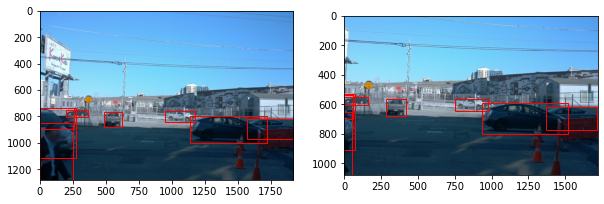

In [51]:
### Displaying the original and cropped image and bounding boxes
display_results(img_to_crop, gt_bboxes_to_crop, cropped_img, cropped_bboxes)

In [52]:
print('Original size:', img_to_crop.size, '\nOutput size:  ', cropped_img.size)

Original size: (1920, 1280) 
Output size:   (1720, 1080)


##### Random cropping

In [53]:
### From Udacity's `augmentations.py`

In [54]:
def random_crop(
        img: Image, bboxes: List[List[int]], 
        crop_size: [int, int], min_area: int=100) -> (Image, List[List[int]]):
    """Randomly crops an image and bounding boxes.
    
    Image is cropped to the desired crop_size.
    Bounding boxes are translated and are discarded if
    their remaining area is less than min_area.

    :param img: the PIL.Image object to crop.
    :param bboxes: the list of original (unmodified) bounding box coordinates.
    :param crop_size: the dimensions of the augmented (modified) image.
    :param min_area: the absolute area threshold determining whether or not
        to preserve a given bounding box after its translation.
    :returns: a tuple containing the augmented (modified) PIL.Image object
        and the list of augmented (modified) bounding box coordinates.
    """
    
    # IMPLEMENT THIS FUNCTION
    assert img.width >= crop_size[0]
    assert img.height >= crop_size[1]
    # Get random starting offset
    x = np.random.randint(low=0, high=(img.width - crop_size[0]))
    y = np.random.randint(low=0, high=(img.height - crop_size[1]))
    crop_start = [x, y]
    crop_end = [x + crop_size[0], y + crop_size[1]]
    cropped_img, bboxes = crop(img, bboxes, crop_start, crop_end)
    crop_coordinates = crop_start + crop_end
    cropped_bboxes = [b for b in bboxes if (
        get_area_intersection(
            crop_coordinates,
            # Reordering coordinates to fit [x1, y1, x2, y2]
            [b[1], b[0], b[3], b[2]]) > min_area)]
    return cropped_img, cropped_bboxes

In [55]:
### Testing random crop on first image in dataset
file_name_img_to_crop_random = 'segment-1231623110026745648_480_000_500_000_with_camera_labels_38.png'
file_path_img_to_crop_random = os.path.join(DIR_SRC, f'images/{file_name_img_to_crop_random}')

In [56]:
### Getting the image ground truth data
gt_bboxes_to_crop_random, gt_classes_to_crop_random = get_gt_bboxes(file_name_img_to_crop_random, ground_truth)

In [57]:
### Staging the image for reading with PIL
img_to_crop_random = Image.open(file_path_img_to_crop_random)

In [58]:
### Performing the random crop of the image and its bounding boxes
crop_size = [512, 512]
(cropped_img_random, 
 cropped_bboxes_random) = random_crop(img_to_crop_random, gt_bboxes_to_crop_random, 
                                      crop_size, min_area=0)

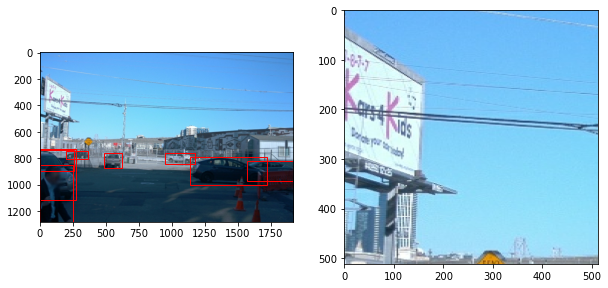

In [59]:
### Displaying the original and randomly-cropped image and bounding boxes
display_results(img_to_crop_random, gt_bboxes_to_crop_random, cropped_img_random, cropped_bboxes_random)

In [60]:
print('Original size:', img_to_crop_random.size, '\nOutput size:  ', cropped_img_random.size)

Original size: (1920, 1280) 
Output size:   (512, 512)


## 3. Closing Remarks

##### Alternatives
* Use [transformation matrices](https://en.wikipedia.org/wiki/Transformation_matrix) to compose affine and projective transformations (consistent formatting).

##### Extensions of task
* Try out more intriguing data augmentation strategies [1] (e.g., colour space augmentation, random erasing, kernel filtering, feature space augmentation, noise injection, etc.).

## 4. Future Work
- [ ] Try out other geometric transformations (e.g., _rotation_, _squeezing_, _stretching_);
- [ ] Build geometric transformations and other augmentation strategies into TensorFlow data ingestion pipelines.

## Credits

This assignment was prepared by Cezanne Camacho, Sudhanshu Kulshrestha and Michael Virgo et al., Winter 2021 (link [here](https://www.udacity.com/course/self-driving-car-engineer-nanodegree--nd0013)).

References
* [1] Shorten, C., Khoshgoftaar, T. A survey on Image Data Augmentation for Deep Learning, Journal of Big Data, 6(1):60, 2019. doi:10.1186/s40537-019-0197-0


Helpful resources:
* [Exercise 1.2.3: commit `#cfee40f` | jonathanloganmoran](https://github.com/jonathanloganmoran/ND0013-Self-Driving-Car-Engineer/blob/cfee40f3f72ea72cbb54c5a6b1403c40a76866d0/1-Object-Detection-in-Urban-Environments/Exercises/1-2-3-Geometric-Transformations/2022-08-23-Geometric-Transformations-Image-Augmentation.ipynb)
    * See last section in commit for commentary on Udacity's `check_results()` tests (re: Issue [#5](https://github.com/jonathanloganmoran/ND0013-Self-Driving-Car-Engineer/issues/5)).
* [Pillow `Image` Module | ReadtheDocs](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image)
* [Basic Image Manipulation | CodinGame](https://www.codingame.com/playgrounds/2524/basic-image-manipulation/transformation)
* [Geometric Transformations | Packt](https://subscription.packtpub.com/book/data/9781800201774/2/ch02lvl1sec09/geometric-transformations)
* [Reflection Transformation | OnlineMathLearning](https://www.onlinemathlearning.com/reflection-transformation.html)